<a href="https://colab.research.google.com/github/VenkataraoGaddam/CourseWork/blob/main/TrafficSign_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import tensorflow as tf
print(tf.__version__)
import keras
print(keras.__version__)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Install keras-cv if not already installed
#!pip install keras-cv
import keras_cv

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from keras import layers, models, applications
from keras.utils import to_categorical, plot_model
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from keras.applications import ResNet50

import os

#from google.colab import drive # Import the drive library

# Mount Google Drive
#drive.mount('/content/drive') # Mount to access files
# Define the path to the GTSRB dataset
#dataset_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/Train'
dataset_path = '/content/GTSRB/Train'

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

2.17.0
3.4.1
Num GPUs Available:  0


In [5]:
data = []
labels = []
classes = 43

for i in range(classes):
  path = os. path.join(dataset_path, str(i))
  images = os.listdir(path)
  for a in images:
    try:
        image = Image.open(path + '/' + a) # Changed '\' to '/' for path separator
        image = image.resize((32,32))
        image = np.array(image)
        data.append(image)
        labels.append(i)
    except Exception as e: # Added Exception handling and print error message
        print(f"Error loading image: {a}, Error: {e}")
data = np.array(data)
labels = np.array(labels)

print(data.shape, labels.shape)
# Preprocessing data - Normilizing and resize
#data = data / 255.0

#Splitting training and testing dataset
X_t1, X_t2, y_t1, y_t2 = train_test_split(data, labels, test_size=0.2, random_state=42)
print(X_t1.shape, X_t2.shape, y_t1.shape, y_t2.shape)

#Converting labels into one hot encoding
y_t1 = to_categorical(y_t1, 43)
y_t2 = to_categorical(y_t2, 43)


(39209, 32, 32, 3) (39209,)
(31367, 32, 32, 3) (7842, 32, 32, 3) (31367,) (7842,)


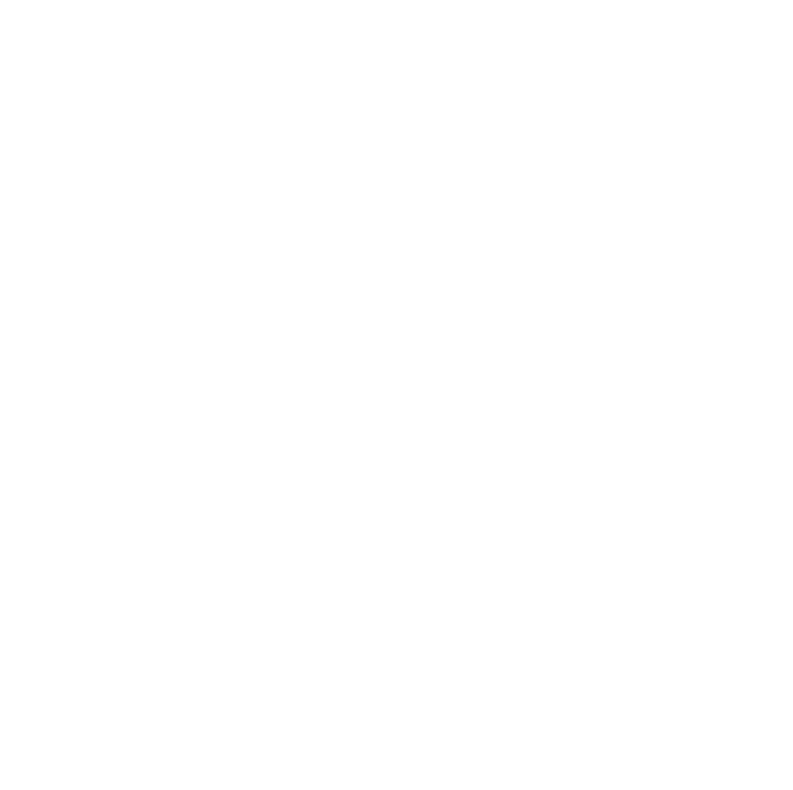

In [6]:
# Data Augmentation using KerasCV
augmenter = keras_cv.layers.Augmenter(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal_and_vertical"),
        keras_cv.layers.RandomRotation(factor=0.2),
        keras_cv.layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
        keras_cv.layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ]
)

# Let's visualize a few augmented examples
def plot_augmented_images(images, augmenter):
    augmented_images = augmenter(images)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i+1)
        plt.imshow(augmented_images[i])
        plt.axis('off')
    plt.show()

# Displaying some augmented images
plot_augmented_images(X_t1[:9], augmenter)

# Data Augmentation Layer Integration into Training Process
def data_generator_with_augmentation(X_t1, y_t1, batch_size):
    while True:
        # Apply data augmentation
        augmented_images = augmenter(X_t1)
        yield augmented_images, y_t1


Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 208s 384ms/step - accuracy: 0.3436 - loss: 2.4988 - val_accuracy: 0.6085 - val_loss: 1.1949
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 176s 332ms/step - accuracy: 0.5987 - loss: 1.2281 - val_accuracy: 0.7031 - val_loss: 0.9114
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 212s 353ms/step - accuracy: 0.6828 - loss: 0.9432 - val_accuracy: 0.7359 - val_loss: 0.7880
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 200s 348ms/step - accuracy: 0.7341 - loss: 0.7859 - val_accuracy: 0.7712 - val_loss: 0.7010
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 170s 346ms/step - accuracy: 0.7662 - loss: 0.6861 - val_accuracy: 0.7859 - val_loss: 0.6671
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 217s 377ms/step - accuracy: 0.7912 - loss: 0.6082 - val_accuracy: 0.8031 - val_loss: 0.6124
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 190s 354ms/step - accuracy: 0.8190 - loss: 0.5291 - val_accuracy: 0.8184 - val_loss: 0.5659
Epoch 8/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 187s 324ms/step - accuracy: 0.8254 -

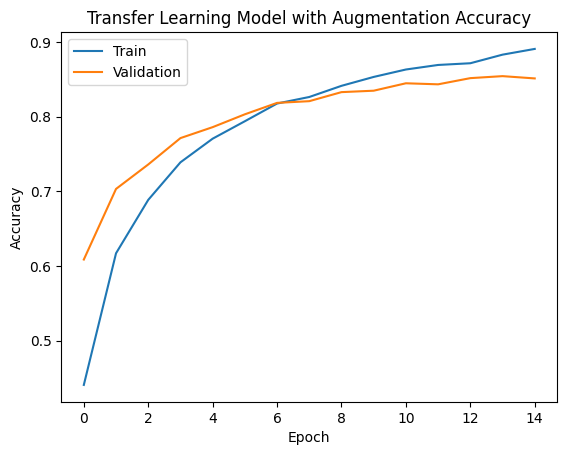

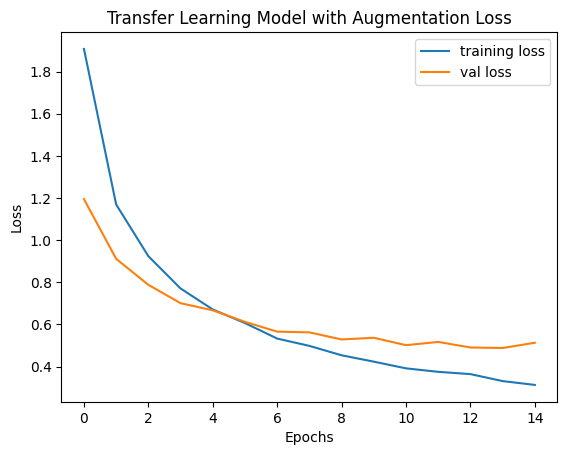

In [10]:
# Transfer Learning with ResNet50
# Load ResNet50 with pre-trained weights and without the top layers

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

# Freeze the layers of ResNet50
for layer in resnet_model.layers:
    layer.trainable = False

# Build a transfer learning model
tl_model = Sequential()
tl_model.add(resnet_model)
tl_model.add(Flatten())
tl_model.add(Dense(256, activation='relu'))
tl_model.add(Dropout(rate=0.25))
tl_model.add(Dense(43, activation='softmax'))

# Compile the model
tl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = tl_model.fit(X_t1, y_t1, batch_size=64, epochs=15, validation_data=(X_t2, y_t2))
# Train the model with augmented data
#batch_size = 64
#history = tl_model.fit(data_generator_with_augmentation(X_t1, y_t1, batch_size),
#                                          epochs=10, steps_per_epoch=len(X_t1) // batch_size,
#                                         validation_data=(X_t2, y_t2))

# Plot training & validation accuracy values for transfer learning
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Transfer Learning Model with Augmentation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Transfer Learning Model with Augmentation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
tl_model.save('Transfer_Learning.keras')

In [12]:

#Building the CNN model
cnn_model = Sequential()
cnn_model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu', input_shape=X_t1.shape[1:]))
cnn_model.add(Conv2D(filters=32, kernel_size=(5,5), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
cnn_model.add(MaxPool2D(pool_size=(2, 2)))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(Flatten())
cnn_model.add(Dense(256, activation='relu'))
cnn_model.add(Dropout(rate=0.25))
cnn_model.add(Dense(43, activation='softmax')) #Compilation of the model
cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
cnn_model.summary()
# Plot the model
plot_model(cnn_model, show_shapes=True, show_dtype=True)
cnn_model.save('Building_CNN.keras')

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)                    │ (None, 28, 28, 32)          │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 24, 24, 32)          │          25,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 12, 12, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 10, 10, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 8, 8, 64)            │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_8 (Dropout)                  │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 256)                 │         262,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 43)                  │          11,051 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 356,939 (1.36 MB)

 Trainable params: 356,939 (1.36 MB)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Model Training and Validation
history = cnn_model.fit(X_t1, y_t1, batch_size=64, epochs=15, validation_data=(X_t2, y_t2))

# Model Training and Validation using Augmented data
#batch_size = 64
#history_aug_cnn = cnn_model.fit(data_generator_with_augmentation(X_t1, y_t1, batch_size),
#                                epochs=10, steps_per_epoch=len(X_t1) // batch_size,
#                                validation_data=(X_t2, y_t2))
cnn_model.save('CNN_Model.keras')


Epoch 1/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 157s 315ms/step - accuracy: 0.2969 - loss: 4.1678 - val_accuracy: 0.8865 - val_loss: 0.5385
Epoch 2/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 195s 302ms/step - accuracy: 0.8147 - loss: 0.6339 - val_accuracy: 0.9654 - val_loss: 0.1440
Epoch 3/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 203s 305ms/step - accuracy: 0.9063 - loss: 0.3193 - val_accuracy: 0.9763 - val_loss: 0.0894
Epoch 4/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 204s 309ms/step - accuracy: 0.9324 - loss: 0.2301 - val_accuracy: 0.9839 - val_loss: 0.0697
Epoch 5/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 198s 301ms/step - accuracy: 0.9471 - loss: 0.1806 - val_accuracy: 0.9874 - val_loss: 0.0508
Epoch 6/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 205s 308ms/step - accuracy: 0.9514 - loss: 0.1643 - val_accuracy: 0.9857 - val_loss: 0.0493
Epoch 7/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 201s 307ms/step - accuracy: 0.9611 - loss: 0.1361 - val_accuracy: 0.9829 - val_loss: 0.0528
Epoch 8/15
491/491 ━━━━━━━━━━━━━━━━━━━━ 148s 302ms/step - accuracy: 0.9599 -

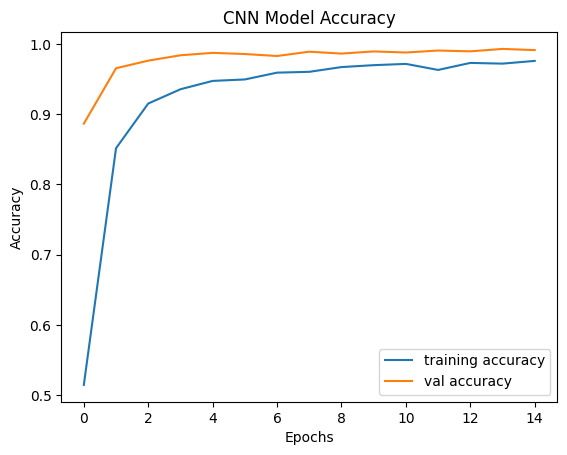

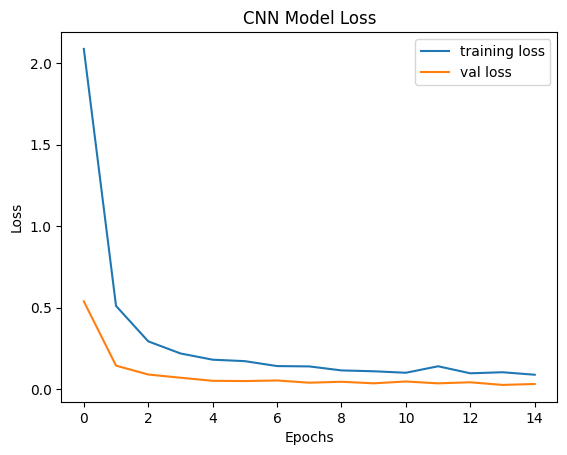

In [14]:
#plotting graphs for accuracy
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('CNN Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('CNN Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Evaulating the model
#loss, accuracy = model.evaluate(X_t2, y_t2, verbose=0)
#print("Loss: ", loss)
#print("Test Accuracy: ", accuracy)

# Evaluate the CNN model with data augmentation
cnn_eval = cnn_model.evaluate(X_t2, y_t2)
print(f'CNN Model Loss: {cnn_eval[0]} | Test Accuracy: {cnn_eval[1]}')

# Evaluate the Transfer Learning model with data augmentation
transfer_eval = tl_model.evaluate(X_t2, y_t2)
print(f'Transfer Learning Loss: {transfer_eval[0]} | Test Accuracy: {transfer_eval[1]}')


246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9908 - loss: 0.0317
CNN Model Loss: 0.031290359795093536 | Test Accuracy: 0.9913287162780762
246/246 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.9908 - loss: 0.0317
Transfer Learning Loss: 0.031290359795093536 | Test Accuracy: 0.9913287162780762


395/395 ━━━━━━━━━━━━━━━━━━━━ 16s 39ms/step
0.958590657165479
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        60
           1       0.97      0.99      0.98       720
           2       0.98      0.97      0.98       750
           3       0.99      0.92      0.95       450
           4       0.99      0.97      0.98       660
           5       0.90      0.98      0.94       630
           6       1.00      0.79      0.88       150
           7       0.96      0.97      0.97       450
           8       0.98      0.96      0.97       450
           9       0.96      0.97      0.97       480
          10       0.98      0.99      0.98       660
          11       0.85      0.93      0.89       420
          12       0.91      0.99      0.95       690
          13       0.97      1.00      0.98       720
          14       0.99      0.99      0.99       270
          15       1.00      0.78      0.87       210
          16       0

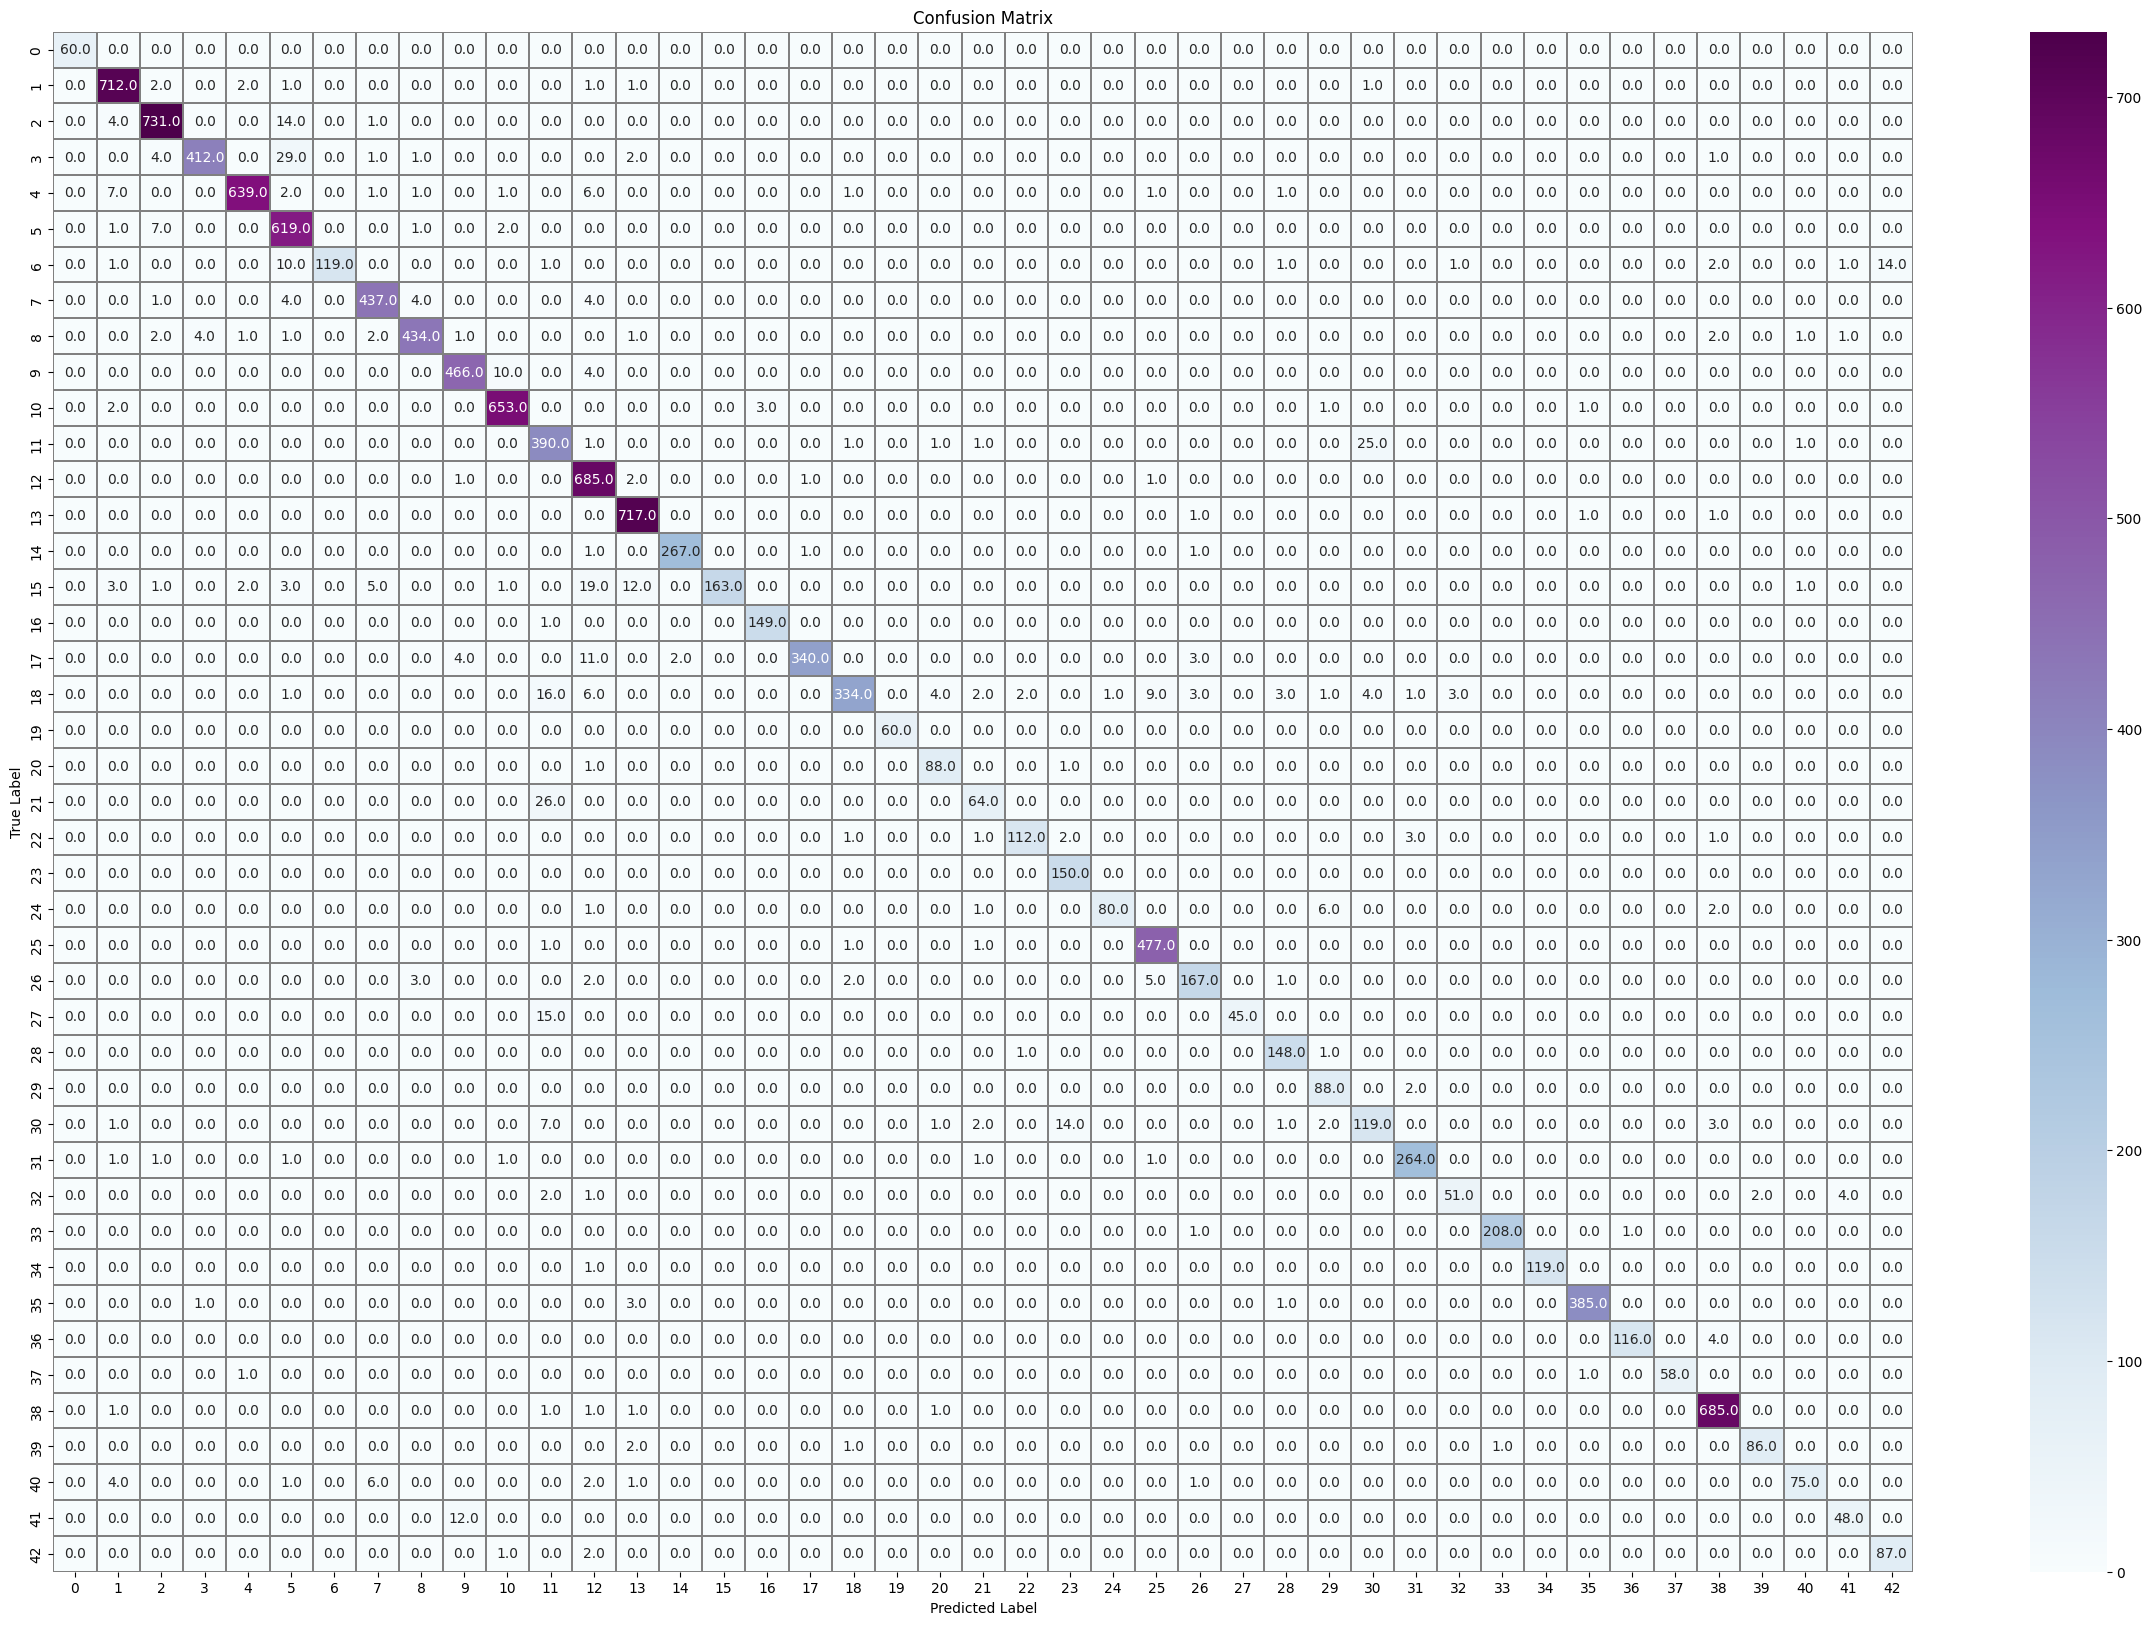

In [19]:
# Model Testing
#testing accuracy on test dataset
#dataset_base_path = '/content/drive/MyDrive/Colab Notebooks/Dataset'
dataset_base_path = '/content/GTSRB'

y_test = pd.read_csv(os.path.join(dataset_base_path, 'Test.csv'))
labels = y_test["ClassId"].values
imgs = y_test["Path"].values
data=[]


for img in imgs:
   full_img_path = os.path.join(dataset_base_path, img)
   image = Image.open(full_img_path)
   #print(full_img_path)
   image = image.resize((32,32))
   data.append(np.array(image))
X_test=np.array(data)

# Classification Report
pred = np.argmax(cnn_model.predict(X_test), axis=-1)

# Accuracy with the test data
print(accuracy_score(labels, pred))
print(classification_report(labels, pred))

# Confusion Matrix
cm = confusion_matrix(labels, pred)
f,ax = plt.subplots(figsize=(30, 20))
sns.heatmap(cm, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt=".1f", ax=ax);
plt.xlabel("Predicted Label");
plt.ylabel("True Label");
plt.title("Confusion Matrix");
plt.show();

cnn_model.save('Traffic_Sign_Classifier.keras')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')